### Meeting Summary: MM (12/10)

| Category | Action Item | Details & References |
| :--- | :--- | :--- |
| **Teaching:**<br>Intro to Ocean. Data Analysis | **Create Python Setup Guide** | Develop an instructional guide or Jupyter Notebook for students on "Setting up Python." |
| | **Convert Module 1** | Translate the first class module from MATLAB to Python. |
| | *Reference* | Use **Bia Villas Bôas'** data GitHub as a primary reference for these teaching materials. |
| **Research / Analysis** | **Compute Setdown** | Calculate setdown on the dataset and analyze how it alters the offset on the nonlinear curve fit. |
| | **Wave Separation** | Apply the **Sheremet and Guza** algorithm to separate incoming vs. outgoing waves. |
| | **Stockdon Comparison** | Calculate the $\chi^2$ of $\sqrt{H_0 L_0}$ (Stockdon) to compare against your current fit. |
| | **Monismith Offset** | Re-evaluate the offset Monismith equation using $H_{s6}$ instead of $H_0$. |

In [1]:
import sys
sys.path.append("..")

#### Setdown 

Becker(2014)

$$ \bar{\eta}_f = \frac{H_f^2k_f}{8sinh(2k_f\bar{h_f})} $$

First, i'd like to write a script that computes setdown from a sensor x array 

In [2]:
## SETDOWN SCRIPT

import pandas as pd
import xarray as xr
import numpy as np

def get_setdownBecker(df: pd.DataFrame, S: xr.Dataset, energy_var: str = 'Seta', depth_col: str = 'h') -> xr.Dataset:
    """
    Calculates wave setdown, significant wave height (Hs), and mean period (Tm) 
    based on spectral data and water depth.

    Parameters:
    -----------
    df : pd.DataFrame
        Raw dataframe containing the water depth series. Must have a DateTime index.
    S : xr.Dataset
        Spectra dataset containing the energy density variable and frequency coordinates.
    energy_var : str, optional
        The name of the energy density variable in `S` (default is 'Seta').
    depth_col : str, optional
        The name of the water depth column in `df` (default is 'h').

    Returns:
    --------
    xr.Dataset
        The original `S` dataset updated with new variables: 'setdown', 'h', 'Hs', and 'Tm'.
    """
    
    # 1. Input Validation
    if depth_col not in df.columns:
        raise ValueError(f"Column '{depth_col}' not found in the provided DataFrame.")
    if energy_var not in S.data_vars:
        raise ValueError(f"Variable '{energy_var}' not found in the provided Dataset.")

    # 2. Interpolate Depth (pandas -> xarray)
    # Convert depth series to xarray DataArray
    h_da = xr.DataArray(
        df[depth_col], 
        coords={'time': df.index},
        dims='time'
    )
    
    # Interpolate depth onto the spectra dataset's time coordinates
    s_h = h_da.interp(time=S.time, method='linear')

    # 3. Calculate Bulk Wave Parameters (Hs and Tm)
    # 0th moment
    m0 = S[energy_var].integrate(coord='frequency')
    # 2nd moment
    m2 = (S[energy_var] * S['frequency']**2).integrate(coord='frequency')
    
    Hs = 4 * np.sqrt(m0)
    # Using zero-crossing period approximation (sqrt(m0/m2))
    Tm = np.sqrt(m0 / m2) 

    # 4. Calculate Wavenumber (k)
    # Internal helper for dispersion relation
    def _get_k_vectorized(T_vals, h_vals, g=9.81):
        """
        Vectorized Newton-Raphson solver for dispersion relation.
        sigma^2 = g * k * tanh(kh)
        """
        sigma = 2 * np.pi / T_vals
        k = sigma**2 / g  # Deep water guess
        
        # 3 iterations is usually sufficient for high precision
        for _ in range(3):
            kh = k * h_vals
            tanh_kh = np.tanh(kh)
            f = (g * k * tanh_kh) - sigma**2
            df_dk = g * (tanh_kh + kh * (1 - tanh_kh**2))
            
            # Avoid division by zero if df_dk is 0 (unlikely in physical range but good practice)
            k = k - f / df_dk
        return k

    k_vals = _get_k_vectorized(Tm.values, s_h.values)
    k = xr.DataArray(k_vals, coords=Tm.coords, name='wavenumber')

    # 5. Calculate Setdown
    # Formula: Setdown = - (Hs^2 * k) / (8 * sinh(2*k*h))
    numerator = - Hs**2 * k
    denominator = 8 * np.sinh(2 * k * s_h)
    
    setdown = numerator / denominator

    # 6. Update and Return Dataset
    # We create a copy to avoid mutating the original dataset implicitly
    S_out = S.copy()
    S_out['setdown'] = setdown
    S_out['h'] = s_h
    S_out['Hs'] = Hs
    S_out['Tm'] = Tm
    
    return S_out

In [3]:
from src.spectra import sensor_spectra
from src.statistics import bin_stats

## 1. load data
    # 1.1. spectra
nperseg = 3600 // 2
df6 = pd.read_parquet('../data_interim/df6.parquet')
S6 = sensor_spectra(df6, nperseg=nperseg)
    # 1.2. bulk params
bulk_df = pd.read_parquet('../data_interim/bulk_df.parquet')

## 2. compute setdown
Sf = get_setdownBecker(df6, S6, energy_var='Seta')
setdown = Sf['setdown'].to_series()

## 3. merge setdown into bulk_df
bulk_df = pd.merge_asof(
    bulk_df,
    setdown.sort_index().to_frame(),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=30)
).dropna()

## 4. compute setup by eta = n + setdown
bulk_df['setup'] = bulk_df['n'] + bulk_df['setdown']

## 5. bin the data
binned_df = bin_stats(
    bulk_df, 
    bin_col='H0', 
    # Add the new columns to this list
    agg_cols=['H0', 'L0', 'n', 'H0L0', 'steepness', 'setdown'], 
    bin_size=0.1
)


<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\e'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_50775/2623966274.py:18: SyntaxWarning: invalid escape sequence '\p'
  label='Binned Avg $\pm$ SEM'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_50775/2623966274.py:22: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('Setup $\eta$ (m)')


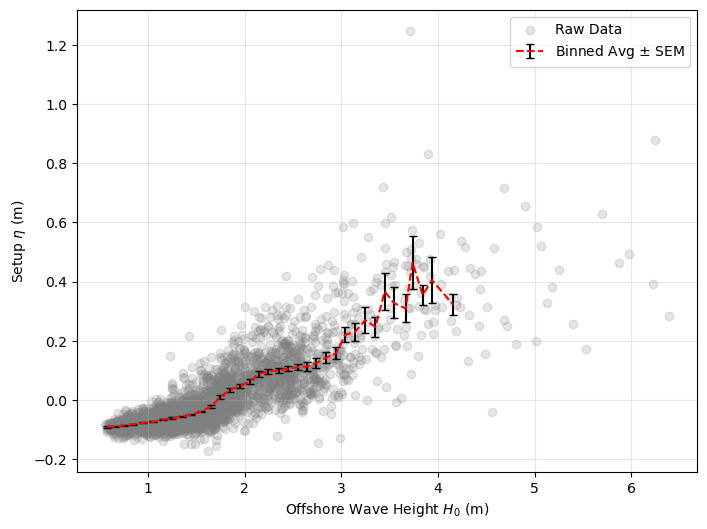

In [4]:
# plotting code
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# original raw data 
plt.scatter(bulk_df['H0'], bulk_df['n'], alpha=0.2, c='gray', label='Raw Data')

# binned averages with Error Bars
plt.errorbar(
    binned_df['H0_mean'], 
    binned_df['n_mean'], 
    yerr=binned_df['n_sem'], 
    fmt='--', 
    color='red', 
    ecolor='black', 
    capsize=3, 
    label='Binned Avg $\pm$ SEM'
)

plt.xlabel('Offshore Wave Height $H_0$ (m)')
plt.ylabel('Setup $\eta$ (m)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
bulk_df

,H0,n,h_tide,L0,H0/L0,H0L0,steepness,Tp,Hs_IG_Nearshore,setdown,setup
time,,,,,,,,,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463,91.624145,0.017955,150.728218,0.017955,14.634210,0.196278,-8.612608e-08,-0.029936
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391,82.591279,0.019696,134.353266,0.019696,13.846214,0.209341,-6.321125e-08,-0.078732
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038,88.654160,0.018448,144.989335,0.018448,14.173290,0.210029,-6.381081e-08,-0.077717
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270,76.812256,0.019691,116.178469,0.019691,13.333391,0.205247,-9.041383e-08,-0.017358
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961,69.346901,0.019951,95.942475,0.019951,13.740518,0.168462,-8.536625e-08,-0.035062
...,...,...,...,...,...,...,...,...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151,140.963989,0.011608,230.658171,0.011608,12.676112,0.256726,-7.538904e-08,0.074588
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928,136.162355,0.013486,250.038532,0.013486,13.333391,0.227943,-7.189168e-08,0.065204
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873,128.485516,0.012754,210.542782,0.012754,12.949697,0.248969,-7.355116e-08,0.045569


Monismith Fit: a=0.0010, b=1.741, c=0.772, d=-0.110
Stockdon Fit: m=0.0196, k=-0.268


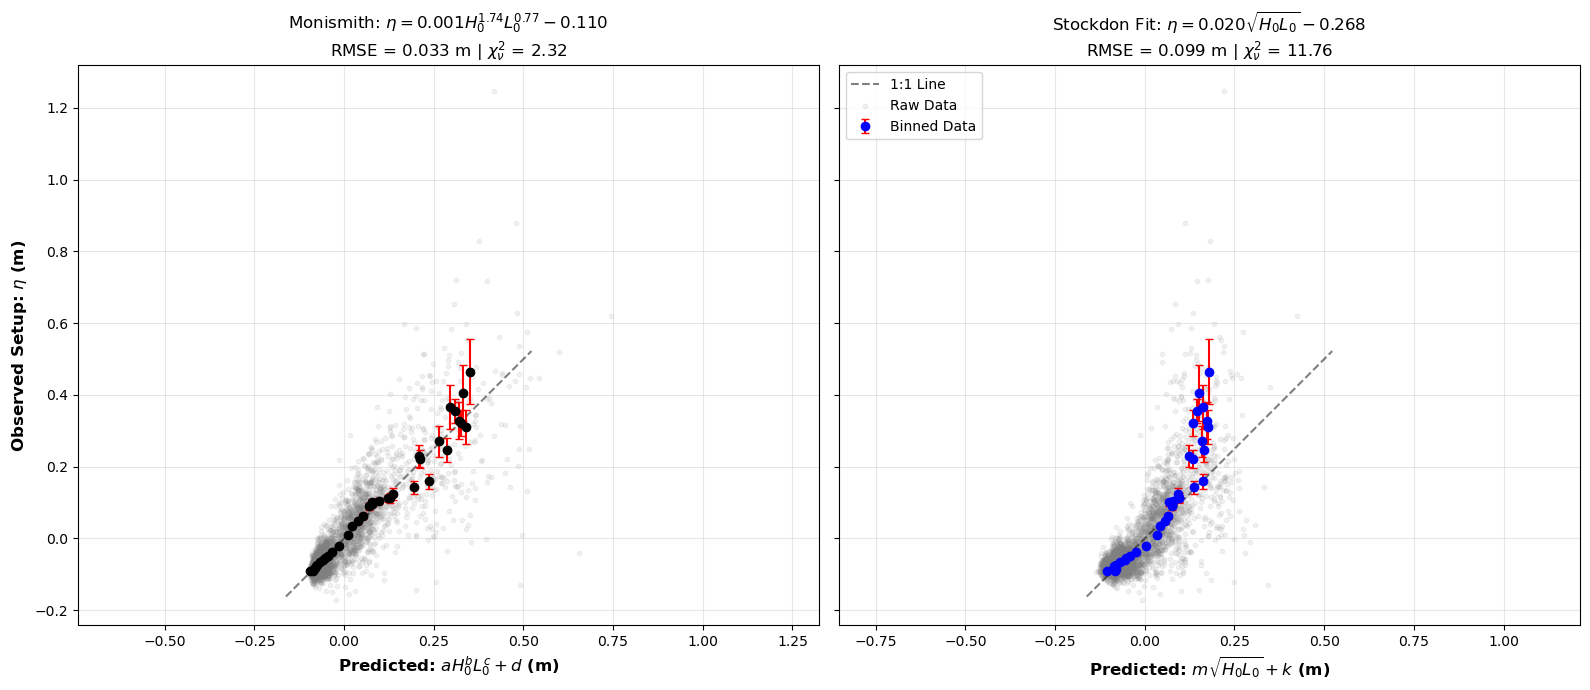

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# --- 1. PREPARE DATA ---
# (Assuming binned_df and bulk_df are already loaded in your environment)
sigma_n = binned_df['n_sem']
y_binned = binned_df['n_mean']
# Stack H0 and L0 for passing to functions
x_binned = np.vstack((binned_df['H0_mean'], binned_df['L0_mean']))

# Raw data for plotting background
raw_clean = bulk_df[['H0', 'L0', 'n']].dropna()
x_raw = np.vstack((raw_clean['H0'], raw_clean['L0']))
y_raw = raw_clean['n']

# --- 2. DEFINE MODELS ---

# Model A: Monismith with Offset
def monismith_offset(X, a, b, c, d):
    H0, L0 = X
    return a * (H0**b) * (L0**c) + d

# Model B: Stockdon (Linear fit to sqrt(H0*L0))
def stockdon_fit(X, m, k):
    H0, L0 = X
    return m * np.sqrt(H0 * L0) + k

# --- 3. FIT MODELS ---

# --- Fit Monismith ---
# Bounds: a(>0), b,c(-5 to 5), d(-0.5 to 0.5)
lb_mon = [0.00001, -5.0, -5.0, -0.5]
ub_mon = [np.inf,   5.0,  5.0,  0.5]
p0_mon = [0.1, -2.0, 0.0, -0.15]

try:
    popt_m, _ = curve_fit(monismith_offset, x_binned, y_binned, 
                          sigma=sigma_n, absolute_sigma=True, 
                          p0=p0_mon, bounds=(lb_mon, ub_mon))
    
    # Predictions
    y_pred_bin_m = monismith_offset(x_binned, *popt_m)
    y_pred_raw_m = monismith_offset(x_raw, *popt_m)
    
    # Metrics (4 parameters)
    res_m = y_binned - y_pred_bin_m
    chi_sq_m = np.sum((res_m / sigma_n)**2) / (len(y_binned) - 4)
    rmse_m = np.sqrt(mean_squared_error(y_binned, y_pred_bin_m))
    
    a, b, c, d = popt_m
    print(f"Monismith Fit: a={a:.4f}, b={b:.3f}, c={c:.3f}, d={d:.3f}")

except Exception as e:
    print(f"Monismith Fit Failed: {e}")
    popt_m = None

# --- Fit Stockdon ---
# We fit m * sqrt(H0L0) + k
# Bounds: m(>0), k(-0.5 to 0.5)
lb_stk = [0.0, -0.5]
ub_stk = [np.inf, 0.5]
p0_stk = [0.06, 0.0] # Initial guess

try:
    popt_s, _ = curve_fit(stockdon_fit, x_binned, y_binned, 
                          sigma=sigma_n, absolute_sigma=True, 
                          p0=p0_stk, bounds=(lb_stk, ub_stk))
    
    # Predictions
    y_pred_bin_s = stockdon_fit(x_binned, *popt_s)
    y_pred_raw_s = stockdon_fit(x_raw, *popt_s)
    
    # Metrics (2 parameters)
    res_s = y_binned - y_pred_bin_s
    chi_sq_s = np.sum((res_s / sigma_n)**2) / (len(y_binned) - 2)
    rmse_s = np.sqrt(mean_squared_error(y_binned, y_pred_bin_s))
    
    m_stk, k_stk = popt_s
    print(f"Stockdon Fit: m={m_stk:.4f}, k={k_stk:.3f}")

except Exception as e:
    print(f"Stockdon Fit Failed: {e}")
    popt_s = None

# --- 4. PLOTTING ---
if popt_m is not None and popt_s is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    
    # Common Plot Limits
    all_preds = np.concatenate([y_pred_bin_m, y_pred_bin_s])
    dmin = min(y_binned.min(), all_preds.min())
    dmax = max(y_binned.max(), all_preds.max())
    pad = (dmax - dmin) * 0.1
    lims = [dmin-pad, dmax+pad]

    # --- SUBPLOT 1: MONISMITH ---
    ax = axes[0]
    ax.plot(lims, lims, 'k--', alpha=0.5, label='1:1 Line')
    ax.scatter(y_pred_raw_m, y_raw, color='gray', s=10, alpha=0.1)
    ax.errorbar(y_pred_bin_m, y_binned, yerr=sigma_n, 
                fmt='o', color='black', ecolor='red', capsize=3, markersize=6)
    
    ax.set_xlabel(rf'Predicted: $a H_0^b L_0^c + d$ (m)', fontsize=12, fontweight='bold')
    ax.set_ylabel(rf'Observed Setup: $\eta$ (m)', fontsize=12, fontweight='bold')
    title_mon = (rf"Monismith: $\eta = {a:.3f} H_0^{{{b:.2f}}} L_0^{{{c:.2f}}} {d:+.3f}$" + "\n" +
                 rf"RMSE = {rmse_m:.3f} m | $\chi_\nu^2$ = {chi_sq_m:.2f}")
    ax.set_title(title_mon, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    ax.set_ylim(-0.2, 0.6) # Adjust as needed

    # --- SUBPLOT 2: STOCKDON ---
    ax = axes[1]
    ax.plot(lims, lims, 'k--', alpha=0.5, label='1:1 Line')
    ax.scatter(y_pred_raw_s, y_raw, color='gray', s=10, alpha=0.1, label='Raw Data')
    ax.errorbar(y_pred_bin_s, y_binned, yerr=sigma_n, 
                fmt='o', color='blue', ecolor='red', capsize=3, markersize=6, label='Binned Data')
    
    ax.set_xlabel(rf'Predicted: $m \sqrt{{H_0 L_0}} + k$ (m)', fontsize=12, fontweight='bold')
    # Y label is shared, so usually skipped on the second plot, but can be added if desired
    
    title_stk = (rf"Stockdon Fit: $\eta = {m_stk:.3f}\sqrt{{H_0 L_0}} {k_stk:+.3f}$" + "\n" +
                 rf"RMSE = {rmse_s:.3f} m | $\chi_\nu^2$ = {chi_sq_s:.2f}")
    ax.set_title(title_stk, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [14]:
from src.bulk_parameters import Hs_band

# compute Hs6
Hs6 = Hs_band(S6, 0.04, 0.33)
H6_ser = Hs6.to_series()

# 1. Create the Series with a specific NAME
# The 'name' parameter becomes the column name in the merged DataFrame
H6 = pd.Series(H6_ser, index=pd.to_datetime(H6_ser.index), name='H6')

# 2. Merge into your existing dataframe (e.g., bulk_df)
# how='outer' keeps all timestamps; how='inner' keeps only matching times
bulk_df = pd.merge(bulk_df, H6, left_index=True, right_index=True, how='outer')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# --- 1. PREPARE DATA ---
# (Assuming binned_df and bulk_df are already loaded in your environment)
sigma_n = binned_df['n_sem']
y_binned = binned_df['n_mean']
# Stack H0 and L0 for passing to functions
x_binned = np.vstack((binned_df['H0_mean'], binned_df['L0_mean']))

# Raw data for plotting background
raw_clean = bulk_df[['H6', 'L0', 'n']].dropna()
x_raw = np.vstack((raw_clean['H6'], raw_clean['L0']))
y_raw = raw_clean['n']

# --- 2. DEFINE MODELS ---

# Model A: Monismith with Offset
def monismith_offset(X, a, b, c, d):
    H6, L0 = X
    return a * (H6**b) * (L0**c) + d

# Model B: Stockdon (Linear fit to sqrt(H6*L0))
def stockdon_fit(X, m, k):
    H6, L0 = X
    return m * np.sqrt(H6 * L0) + k

# --- 3. FIT MODELS ---

# --- Fit Monismith ---
# Bounds: a(>0), b,c(-5 to 5), d(-0.5 to 0.5)
lb_mon = [0.00001, -5.0, -5.0, -0.5]
ub_mon = [np.inf,   5.0,  5.0,  0.5]
p0_mon = [0.1, -2.0, 0.0, -0.15]

try:
    popt_m, _ = curve_fit(monismith_offset, x_binned, y_binned, 
                          sigma=sigma_n, absolute_sigma=True, 
                          p0=p0_mon, bounds=(lb_mon, ub_mon))
    
    # Predictions
    y_pred_bin_m = monismith_offset(x_binned, *popt_m)
    y_pred_raw_m = monismith_offset(x_raw, *popt_m)
    
    # Metrics (4 parameters)
    res_m = y_binned - y_pred_bin_m
    chi_sq_m = np.sum((res_m / sigma_n)**2) / (len(y_binned) - 4)
    rmse_m = np.sqrt(mean_squared_error(y_binned, y_pred_bin_m))
    
    a, b, c, d = popt_m
    print(f"Monismith Fit: a={a:.4f}, b={b:.3f}, c={c:.3f}, d={d:.3f}")

except Exception as e:
    print(f"Monismith Fit Failed: {e}")
    popt_m = None

# --- Fit Stockdon ---
# We fit m * sqrt(H0L0) + k
# Bounds: m(>0), k(-0.5 to 0.5)
lb_stk = [0.0, -0.5]
ub_stk = [np.inf, 0.5]
p0_stk = [0.06, 0.0] # Initial guess

try:
    popt_s, _ = curve_fit(stockdon_fit, x_binned, y_binned, 
                          sigma=sigma_n, absolute_sigma=True, 
                          p0=p0_stk, bounds=(lb_stk, ub_stk))
    
    # Predictions
    y_pred_bin_s = stockdon_fit(x_binned, *popt_s)
    y_pred_raw_s = stockdon_fit(x_raw, *popt_s)
    
    # Metrics (2 parameters)
    res_s = y_binned - y_pred_bin_s
    chi_sq_s = np.sum((res_s / sigma_n)**2) / (len(y_binned) - 2)
    rmse_s = np.sqrt(mean_squared_error(y_binned, y_pred_bin_s))
    
    m_stk, k_stk = popt_s
    print(f"Stockdon Fit: m={m_stk:.4f}, k={k_stk:.3f}")

except Exception as e:
    print(f"Stockdon Fit Failed: {e}")
    popt_s = None

# --- 4. PLOTTING ---
if popt_m is not None and popt_s is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    
    # Common Plot Limits
    all_preds = np.concatenate([y_pred_bin_m, y_pred_bin_s])
    dmin = min(y_binned.min(), all_preds.min())
    dmax = max(y_binned.max(), all_preds.max())
    pad = (dmax - dmin) * 0.1
    lims = [dmin-pad, dmax+pad]

    # --- SUBPLOT 1: MONISMITH ---
    ax = axes[0]
    ax.plot(lims, lims, 'k--', alpha=0.5, label='1:1 Line')
    ax.scatter(y_pred_raw_m, y_raw, color='gray', s=10, alpha=0.1)
    ax.errorbar(y_pred_bin_m, y_binned, yerr=sigma_n, 
                fmt='o', color='black', ecolor='red', capsize=3, markersize=6)
    
    ax.set_xlabel(rf'Predicted: $a H_0^b L_0^c + d$ (m)', fontsize=12, fontweight='bold')
    ax.set_ylabel(rf'Observed Setup: $\eta$ (m)', fontsize=12, fontweight='bold')
    title_mon = (rf"Monismith: $\eta = {a:.3f} H_0^{{{b:.2f}}} L_0^{{{c:.2f}}} {d:+.3f}$" + "\n" +
                 rf"RMSE = {rmse_m:.3f} m | $\chi_\nu^2$ = {chi_sq_m:.2f}")
    ax.set_title(title_mon, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    ax.set_ylim(-0.2, 0.6) # Adjust as needed

    # --- SUBPLOT 2: STOCKDON ---
    ax = axes[1]
    ax.plot(lims, lims, 'k--', alpha=0.5, label='1:1 Line')
    ax.scatter(y_pred_raw_s, y_raw, color='gray', s=10, alpha=0.1, label='Raw Data')
    ax.errorbar(y_pred_bin_s, y_binned, yerr=sigma_n, 
                fmt='o', color='blue', ecolor='red', capsize=3, markersize=6, label='Binned Data')
    
    ax.set_xlabel(rf'Predicted: $m \sqrt{{H_0 L_0}} + k$ (m)', fontsize=12, fontweight='bold')
    # Y label is shared, so usually skipped on the second plot, but can be added if desired
    
    title_stk = (rf"Stockdon Fit: $\eta = {m_stk:.3f}\sqrt{{H_0 L_0}} {k_stk:+.3f}$" + "\n" +
                 rf"RMSE = {rmse_s:.3f} m | $\chi_\nu^2$ = {chi_sq_s:.2f}")
    ax.set_title(title_stk, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

,H0,n,h_tide,L0,H0/L0,H0L0,steepness,Tp,Hs_IG_Nearshore,setdown,setup,H6
time,,,,,,,,,,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463,91.624145,0.017955,150.728218,0.017955,14.634210,0.196278,-8.612608e-08,-0.029936,1.786121
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391,82.591279,0.019696,134.353266,0.019696,13.846214,0.209341,-6.321125e-08,-0.078732,1.726074
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038,88.654160,0.018448,144.989335,0.018448,14.173290,0.210029,-6.381081e-08,-0.077717,1.752083
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270,76.812256,0.019691,116.178469,0.019691,13.333391,0.205247,-9.041383e-08,-0.017358,1.579092
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961,69.346901,0.019951,95.942475,0.019951,13.740518,0.168462,-8.536625e-08,-0.035062,1.463238
...,...,...,...,...,...,...,...,...,...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151,140.963989,0.011608,230.658171,0.011608,12.676112,0.256726,-7.538904e-08,0.074588,1.705907
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928,136.162355,0.013486,250.038532,0.013486,13.333391,0.227943,-7.189168e-08,0.065204,1.926385
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873,128.485516,0.012754,210.542782,0.012754,12.949697,0.248969,-7.355116e-08,0.045569,1.709467


In [18]:
# 2. Run bin_stats binning by H6
binned_df = bin_stats(
    df=bulk_df,
    bin_col='H6',                # <--- Set H6 as the binning edge
    agg_cols=['H6', 'L0', 'n'],  # <--- MUST include 'H6' here to get H6_mean
    num_bins=20
)

# Now binned_df will contain: 'H6_mean', 'L0_mean', 'n_mean', etc.
print(binned_df.columns)

Index(['H6_mean', 'H6_std', 'H6_count', 'L0_mean', 'L0_std', 'L0_count',
       'n_mean', 'n_std', 'n_count', 'H6_sem', 'L0_sem', 'n_sem'],
      dtype='object')


Monismith Fit: a=0.0021, b=1.333, c=0.702, d=-0.129
Stockdon Fit: m=0.0200, k=-0.274


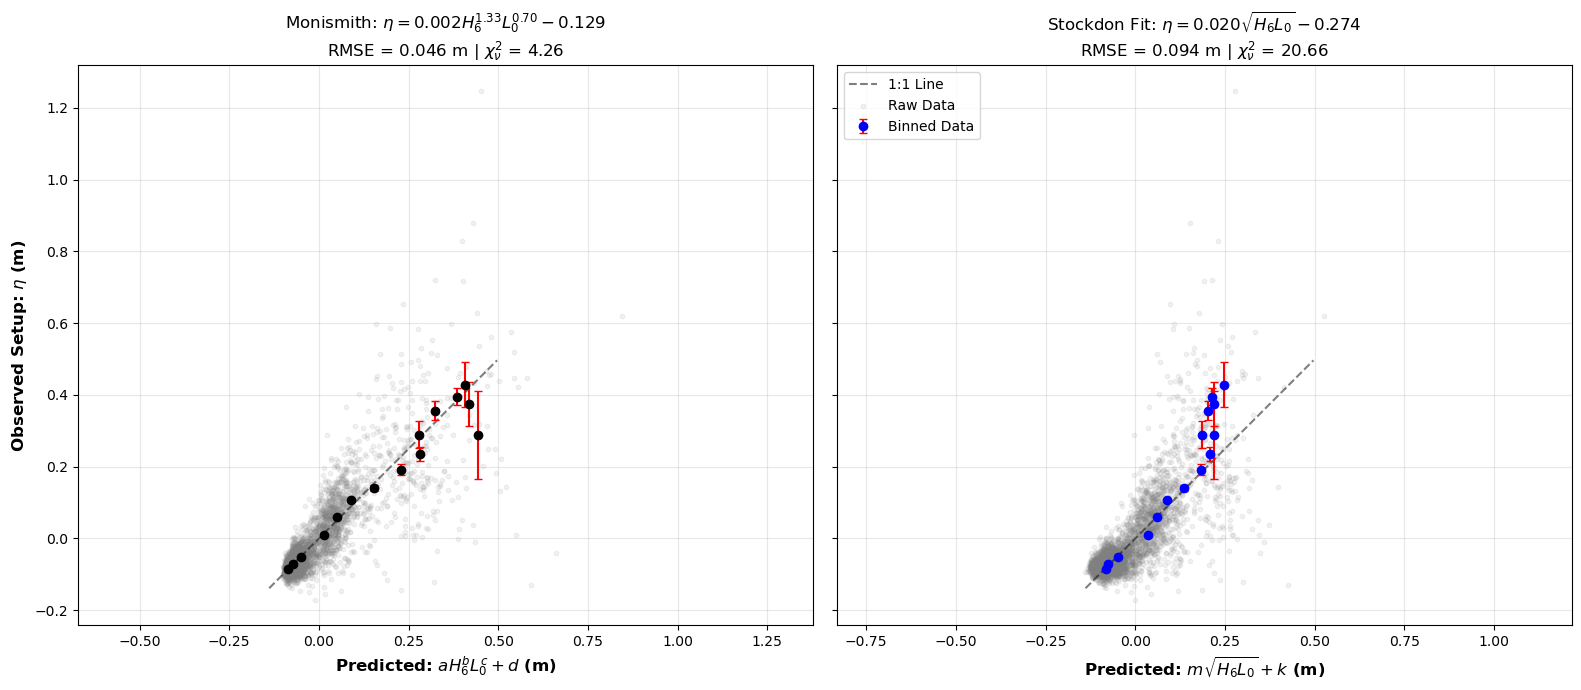

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# --- 1. PREPARE DATA ---
sigma_n = binned_df['n_sem']
y_binned = binned_df['n_mean']

# !!! FIX 1: Use H6_mean here (make sure this column exists in binned_df)
x_binned = np.vstack((binned_df['H6_mean'], binned_df['L0_mean']))

# Raw data
raw_clean = bulk_df[['H6', 'L0', 'n']].dropna()
x_raw = np.vstack((raw_clean['H6'], raw_clean['L0']))
y_raw = raw_clean['n']

# --- 2. DEFINE MODELS ---
def monismith_offset(X, a, b, c, d):
    H6, L0 = X
    return a * (H6**b) * (L0**c) + d

def stockdon_fit(X, m, k):
    H6, L0 = X
    return m * np.sqrt(H6 * L0) + k

# --- 3. FIT MODELS ---

# --- Fit Monismith ---
lb_mon = [0.00001, -5.0, -5.0, -0.5]
ub_mon = [np.inf,   5.0,  5.0,  0.5]
p0_mon = [0.1, -2.0, 0.0, -0.15]

try:
    popt_m, _ = curve_fit(monismith_offset, x_binned, y_binned, 
                          sigma=sigma_n, absolute_sigma=True, 
                          p0=p0_mon, bounds=(lb_mon, ub_mon))
    
    y_pred_bin_m = monismith_offset(x_binned, *popt_m)
    y_pred_raw_m = monismith_offset(x_raw, *popt_m)
    
    res_m = y_binned - y_pred_bin_m
    chi_sq_m = np.sum((res_m / sigma_n)**2) / (len(y_binned) - 4)
    rmse_m = np.sqrt(mean_squared_error(y_binned, y_pred_bin_m))
    
    a, b, c, d = popt_m
    print(f"Monismith Fit: a={a:.4f}, b={b:.3f}, c={c:.3f}, d={d:.3f}")

except Exception as e:
    print(f"Monismith Fit Failed: {e}")
    popt_m = None

# --- Fit Stockdon ---
lb_stk = [0.0, -0.5]
ub_stk = [np.inf, 0.5]
p0_stk = [0.06, 0.0]

try:
    popt_s, _ = curve_fit(stockdon_fit, x_binned, y_binned, 
                          sigma=sigma_n, absolute_sigma=True, 
                          p0=p0_stk, bounds=(lb_stk, ub_stk))
    
    y_pred_bin_s = stockdon_fit(x_binned, *popt_s)
    y_pred_raw_s = stockdon_fit(x_raw, *popt_s)
    
    res_s = y_binned - y_pred_bin_s
    chi_sq_s = np.sum((res_s / sigma_n)**2) / (len(y_binned) - 2)
    rmse_s = np.sqrt(mean_squared_error(y_binned, y_pred_bin_s))
    
    m_stk, k_stk = popt_s
    print(f"Stockdon Fit: m={m_stk:.4f}, k={k_stk:.3f}")

except Exception as e:
    print(f"Stockdon Fit Failed: {e}")
    popt_s = None

# --- 4. PLOTTING ---
if popt_m is not None and popt_s is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    
    all_preds = np.concatenate([y_pred_bin_m, y_pred_bin_s])
    dmin = min(y_binned.min(), all_preds.min())
    dmax = max(y_binned.max(), all_preds.max())
    pad = (dmax - dmin) * 0.1
    lims = [dmin-pad, dmax+pad]

    # --- SUBPLOT 1: MONISMITH ---
    ax = axes[0]
    ax.plot(lims, lims, 'k--', alpha=0.5, label='1:1 Line')
    ax.scatter(y_pred_raw_m, y_raw, color='gray', s=10, alpha=0.1)
    ax.errorbar(y_pred_bin_m, y_binned, yerr=sigma_n, 
                fmt='o', color='black', ecolor='red', capsize=3, markersize=6)
    
    # !!! FIX 2: Update Label to H6
    ax.set_xlabel(rf'Predicted: $a H_6^b L_0^c + d$ (m)', fontsize=12, fontweight='bold')
    ax.set_ylabel(rf'Observed Setup: $\eta$ (m)', fontsize=12, fontweight='bold')
    title_mon = (rf"Monismith: $\eta = {a:.3f} H_6^{{{b:.2f}}} L_0^{{{c:.2f}}} {d:+.3f}$" + "\n" +
                 rf"RMSE = {rmse_m:.3f} m | $\chi_\nu^2$ = {chi_sq_m:.2f}")
    ax.set_title(title_mon, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    ax.set_ylim(-0.2, 0.6) 

    # --- SUBPLOT 2: STOCKDON ---
    ax = axes[1]
    ax.plot(lims, lims, 'k--', alpha=0.5, label='1:1 Line')
    ax.scatter(y_pred_raw_s, y_raw, color='gray', s=10, alpha=0.1, label='Raw Data')
    ax.errorbar(y_pred_bin_s, y_binned, yerr=sigma_n, 
                fmt='o', color='blue', ecolor='red', capsize=3, markersize=6, label='Binned Data')
    
    # !!! FIX 3: Update Label to H6
    ax.set_xlabel(rf'Predicted: $m \sqrt{{H_6 L_0}} + k$ (m)', fontsize=12, fontweight='bold')
    
    title_stk = (rf"Stockdon Fit: $\eta = {m_stk:.3f}\sqrt{{H_6 L_0}} {k_stk:+.3f}$" + "\n" +
                 rf"RMSE = {rmse_s:.3f} m | $\chi_\nu^2$ = {chi_sq_s:.2f}")
    ax.set_title(title_stk, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [17]:
binned_df

,H0_mean,H0_std,H0_count,L0_mean,L0_std,L0_count,n_mean,n_std,n_count,H0L0_mean,...,steepness_count,setdown_mean,setdown_std,setdown_count,H0_sem,L0_sem,n_sem,H0L0_sem,steepness_sem,setdown_sem
0,0.576098,0.012128,8,119.378614,12.792140,8,-0.090554,0.011189,8,68.725396,...,8,-2.386840e-09,1.007913e-09,8,0.004288,4.522704,0.003956,2.467334,0.000223,3.563510e-10
1,0.658773,0.027603,77,135.119543,35.934925,77,-0.089376,0.013597,77,88.960679,...,77,-3.620465e-09,2.906515e-09,77,0.003146,4.095165,0.001550,2.720847,0.000134,3.312281e-10
2,0.751944,0.028076,117,121.206032,30.783891,117,-0.085279,0.017908,117,91.117089,...,117,-7.806208e-09,1.568104e-08,117,0.002596,2.845972,0.001656,2.149763,0.000120,1.449713e-09
3,0.848764,0.029844,102,104.655226,35.604861,102,-0.081251,0.018028,102,88.442928,...,102,-2.887473e-08,1.100392e-07,102,0.002955,3.525407,0.001785,2.881673,0.000264,1.089550e-08
4,0.952826,0.029349,173,90.151623,22.964306,173,-0.076940,0.019946,173,85.881294,...,173,-3.900670e-08,1.798346e-07,173,0.002231,1.745944,0.001516,1.685459,0.000199,1.367257e-08
5,1.055265,0.028332,225,86.174794,25.463671,225,-0.073213,0.022236,225,90.884935,...,225,-3.191663e-08,4.430222e-08,225,0.001889,1.697578,0.001482,1.788225,0.000232,2.953481e-09
6,1.150438,0.027783,288,88.608661,26.393417,288,-0.066402,0.024042,288,102.009721,...,288,-5.100543e-08,1.684694e-07,288,0.001637,1.555247,0.001417,1.814972,0.000228,9.927154e-09
7,1.249696,0.027884,255,94.323064,29.101052,255,-0.060472,0.032646,255,117.833796,...,255,-5.264471e-08,1.084458e-07,255,0.001746,1.822379,0.002044,2.279537,0.000248,6.791140e-09
8,1.351192,0.029285,251,89.791838,33.547060,251,-0.055082,0.032320,251,121.255913,...,251,-9.218028e-08,4.091683e-07,251,0.001848,2.117472,0.002040,2.847439,0.000292,2.582647e-08
9,1.449792,0.027489,279,91.099016,37.757313,279,-0.048991,0.037412,279,132.166005,...,279,-8.926420e-08,2.535240e-07,279,0.001646,2.260471,0.002240,3.305998,0.000308,1.517808e-08
